## Diagnostic of EarthCARE data of TCs

TODO: Update my IBTrACS file and re-do the collocation procedure because some tracks became much shorter in the last version (30042025) I use.

CAVEAT: When I plot all EC tracks in a reference frame moving with the TC, I flipped the Southern hemisphere storms.

In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
import pandas as pd 
from tqdm.notebook import tqdm
import ephem
import seaborn as sns
import re
from datetime import datetime
from pyproj import CRS, Geod

# Custom
import sys
sys.path.append('../ectools')
from ectools import ecio
from ectools import ecplot as ecplt
from ectools import colormaps

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PTHS = {
    # 'sar_pth': '/home/arthur/results/sar_extended/05_addPRIMED/dsg.nc',
    'ear_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/02_EARTHCARE_DIAGNOSTIC/'
}

# Open SAR
# dsg      = xr.open_dataset(PTHS['sar_pth'])

# Open EarthCARE
all_data = glob.glob(PTHS['ear_dir'] + '*.nc')
all_data.sort()

In [3]:
# # Test
# all_data = ['/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20240915T172841Z_20240915T232259Z_01708B.nc']

In [4]:
ACTC_category_colors = [sns.xkcd_rgb['silver'],         #unknown
                        sns.xkcd_rgb['reddish brown'],         #surface and subsurface
                        sns.xkcd_rgb['white'],         #clear
                        sns.xkcd_rgb['dull red'],      #rain in clutter
                        sns.xkcd_rgb['off blue'],     #snow in clutter
                        sns.xkcd_rgb['dull yellow'],   #cloud in clutter
                        sns.xkcd_rgb['dark red'],      #heavy rain',
                        sns.xkcd_rgb["navy blue"],   #heavy mixed-phase precipitation
                        sns.xkcd_rgb['light grey'],    #clear (poss. liquid) 
                        sns.xkcd_rgb['pale yellow'],   #liquid cloud
                        sns.xkcd_rgb['golden'],        #drizzling liquid
                        sns.xkcd_rgb['orange'],        #warm rain
                        sns.xkcd_rgb['bright red'],    #cold rain
                        sns.xkcd_rgb['easter purple'], # melting snow
                        sns.xkcd_rgb['dark sky blue'],        # snow (possible liquid)
                        sns.xkcd_rgb['bright blue'], # snow
                        sns.xkcd_rgb["prussian blue"],   # rimed snow (poss. liquid)
                        sns.xkcd_rgb['dark teal'],   # rimed snow and SLW
                        sns.xkcd_rgb['teal'],              # snow and SLW
                        sns.xkcd_rgb['light green'],   # supercooled liquid
                        sns.xkcd_rgb["sky blue"],      # ice (poss. liquid)
                        sns.xkcd_rgb['bright teal'],   # ice and SLW
                        sns.xkcd_rgb['light blue'],    # ice (no liquid)
                        sns.xkcd_rgb['pale blue'],     # strat. ice, PSC II
                        sns.xkcd_rgb['neon green'],    # PSC Ia
                        sns.xkcd_rgb['greenish cyan'], # PSC Ib
                        sns.xkcd_rgb['ugly green'],    # insects
                        sns.xkcd_rgb['sand'],          # dust
                        sns.xkcd_rgb['pastel pink'],   # sea salt
                        sns.xkcd_rgb['dust'],          # continental pollution
                        sns.xkcd_rgb['purpley grey'],  # smoke
                        sns.xkcd_rgb['dark lavender'], # dusty smoke
                        sns.xkcd_rgb['dusty lavender'],# dusty mix
                        sns.xkcd_rgb['pinkish grey'],  # stratospheric aerosol 1 (ash)
                        sns.xkcd_rgb['light khaki'],       # stratospheric aerosol 2 (sulphate)
                        sns.xkcd_rgb['light grey'],    # stratospheric aerosol 3 (smoke)]
                  ]

hmax = 20000

### Histogram of data w.r.t distance from center and category

In [5]:
MIN_DIS2CEN        = []
MIN_DIS2CEN_STRONG = []

for file in tqdm(all_data):
    ds = xr.open_dataset(file)

    if ds.closest_distance_to_track_center_ibt < 5000:
        print(ds.vmx_ibt.values)
        print(ds.file.item())
        print(file)

    if ds.vmx_ibt >= 33:
        MIN_DIS2CEN_STRONG.append(float(ds.closest_distance_to_track_center_ibt))
    
    MIN_DIS2CEN.append(float(ds.closest_distance_to_track_center_ibt))

    ds.close()

  0%|          | 0/418 [00:00<?, ?it/s]

32.66655269007365
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/10/28/ECA_EXAA_AC__TC__2B_20241028T170932Z_20241028T230948Z_02377A.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241028T170932Z_20241028T230948Z_02377A.nc


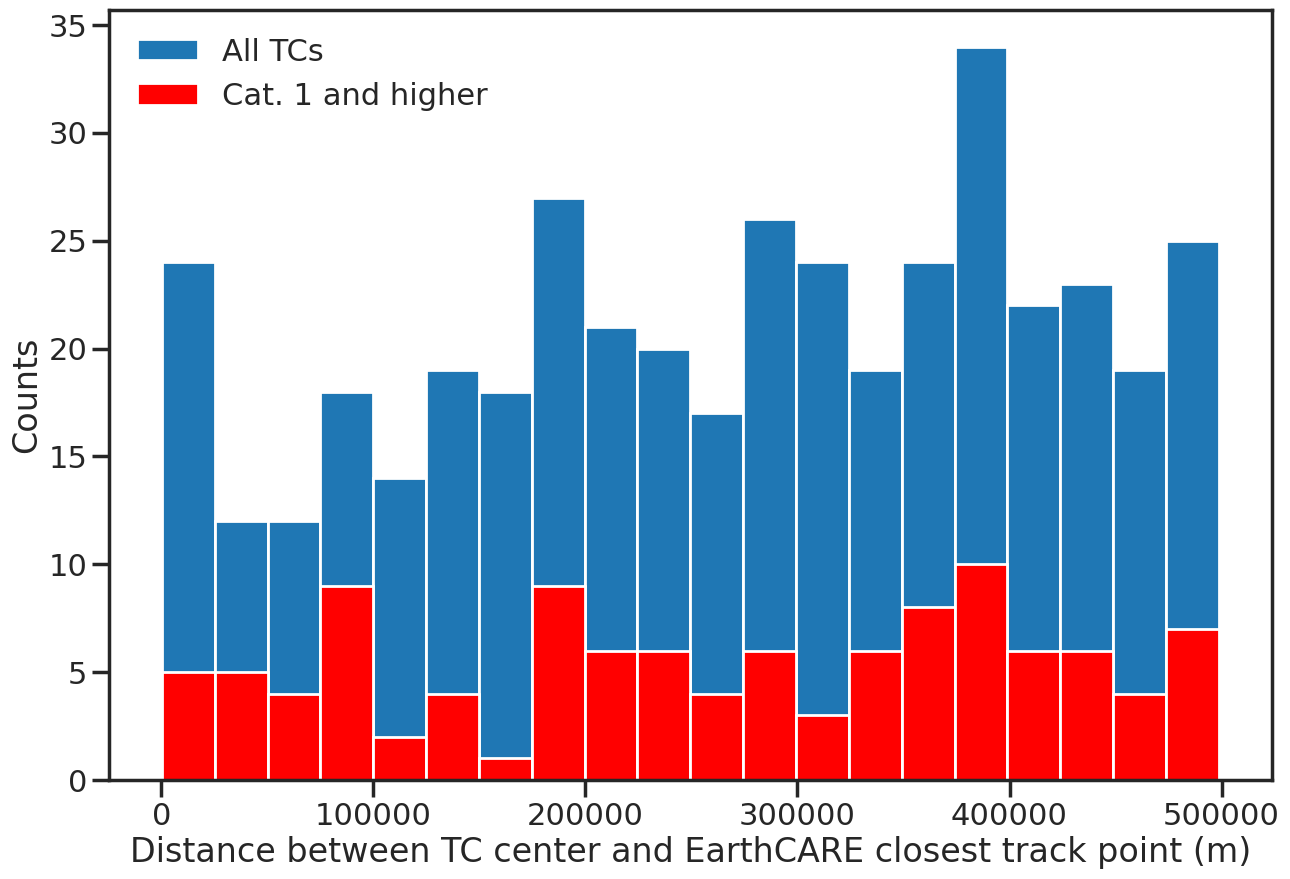

In [6]:
_, bins, _,  = plt.hist(MIN_DIS2CEN, bins=20, label='All TCs')
plt.hist(MIN_DIS2CEN_STRONG, bins=bins, color='red', label='Cat. 1 and higher')

plt.xlabel('Distance between TC center and EarthCARE closest track point (m)')
plt.ylabel('Counts')
plt.legend(frameon=False)

# plt.savefig(PTHS['sav_dir'] + 'Histogram_EarthCARE_data_on_TCs.png', bbox_inches='tight')

In [7]:
# p      = '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241010T050822Z_20241010T104634Z_02089B.nc'
# leslie = xr.open_dataset(p)
# print(leslie.closest_distance_to_track_center_ibt.values)

### Plotting the overpasses that are close to a TC center

  0%|          | 0/418 [00:00<?, ?it/s]

36.007999420166016
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/09/15/ECA_EXAA_AC__TC__2B_20240915T172841Z_20240915T232259Z_01708B.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20240915T172841Z_20240915T232259Z_01708B.nc
30.5 123.39891100009389

2024-09-15T17:34:33.985041282
Vmax = 36.0 m/s
Rmax = 27.8 km 
Trimming by latitude


44.216323079685395
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/10/10/ECA_EXAA_AC__TC__2B_20241010T045647Z_20241010T104700Z_02089A.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241010T045647Z_20241010T104700Z_02089A.nc
22.56809748665187 -49.57238918366803
AL132024
2024-10-10T05:02:34.500543145
Vmax = 44.2 m/s
Rmax = 18.5 km 
Trimming by latitude


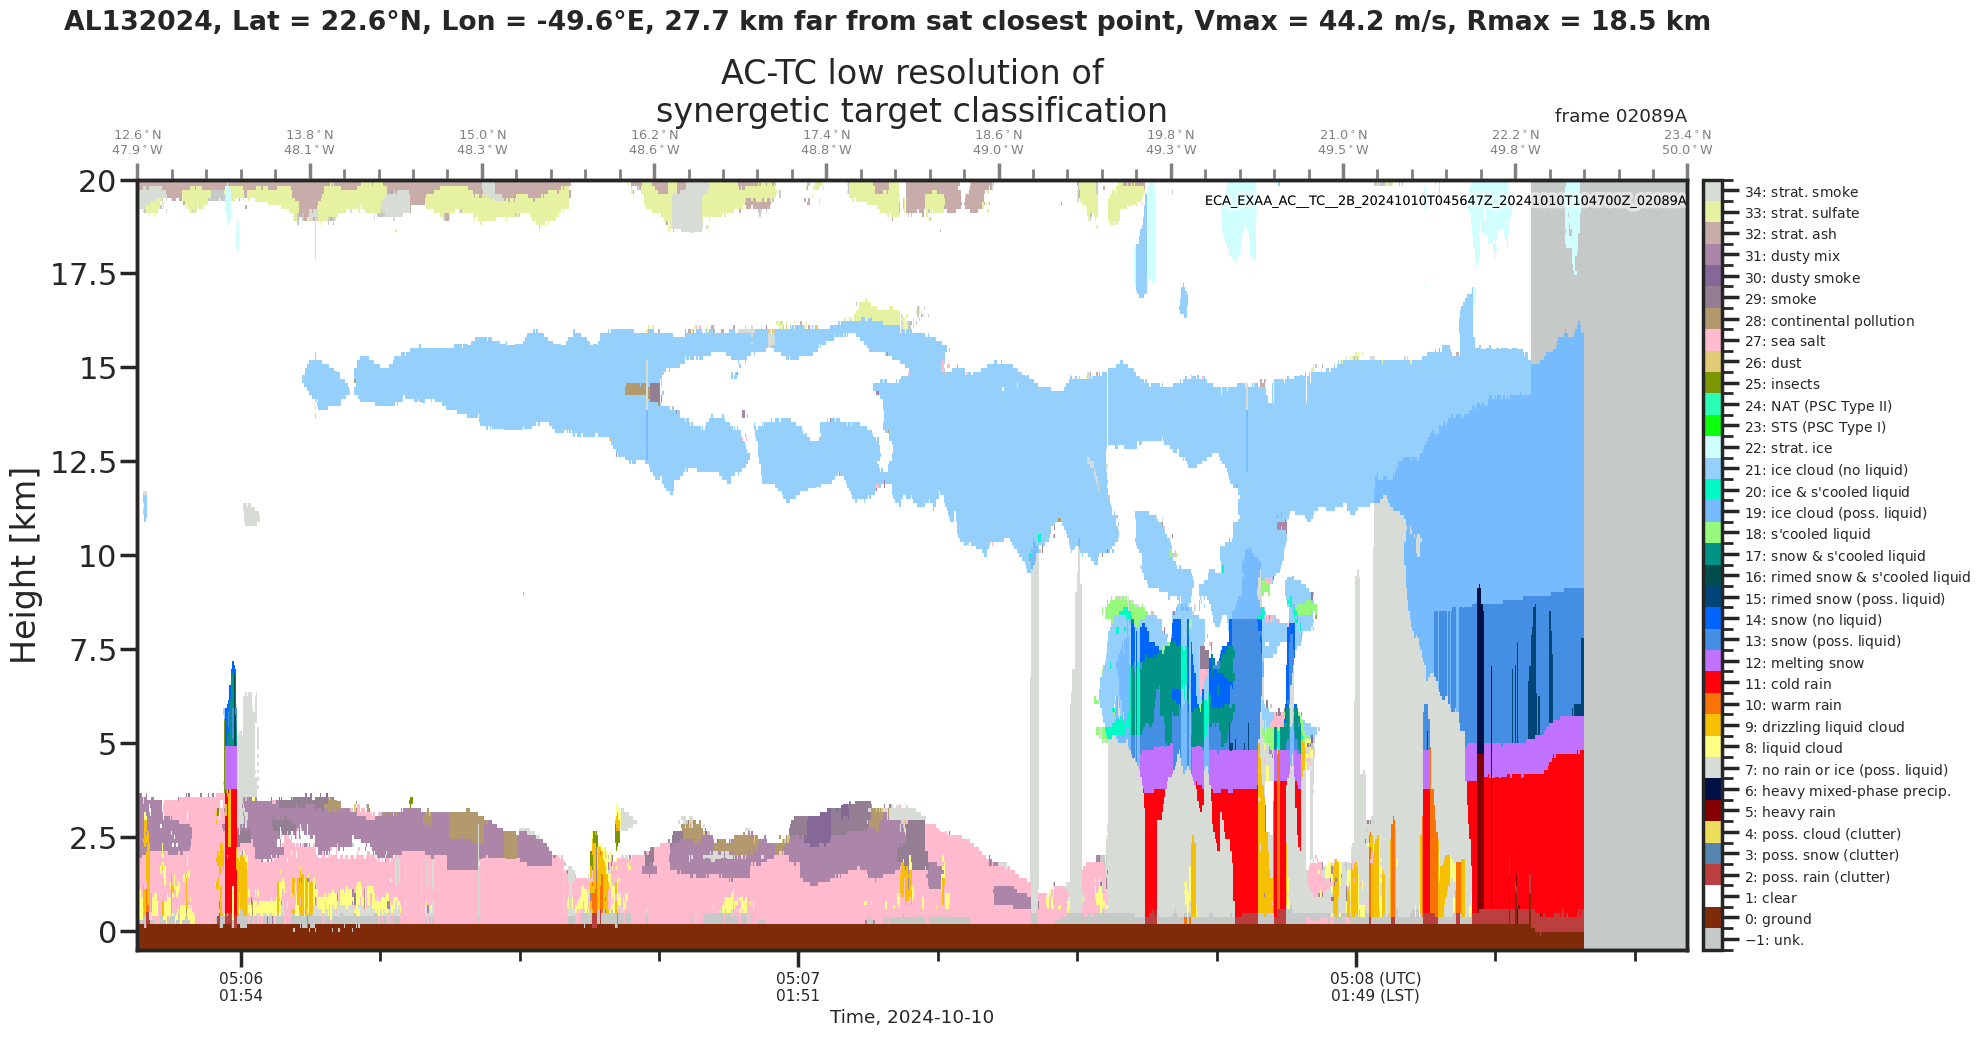

44.116146152417066
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/10/10/ECA_EXAA_AC__TC__2B_20241010T050822Z_20241010T104634Z_02089B.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241010T050822Z_20241010T104634Z_02089B.nc
22.574589011762736 -49.5983552841115
AL132024
2024-10-10T05:14:15.582580703
Vmax = 44.1 m/s
Rmax = 18.5 km 
Trimming by latitude


37.978406425755104
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/11/13/ECA_EXAA_AC__TC__2B_20241113T053855Z_20241113T085528Z_02618E.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241113T053855Z_20241113T085528Z_02618E.nc
15.574574186827641 126.55085222762888

2024-11-13T05:44:44.657614780
Vmax = 38.0 m/s
Rmax = 31.5 km 
Trimming by latitude


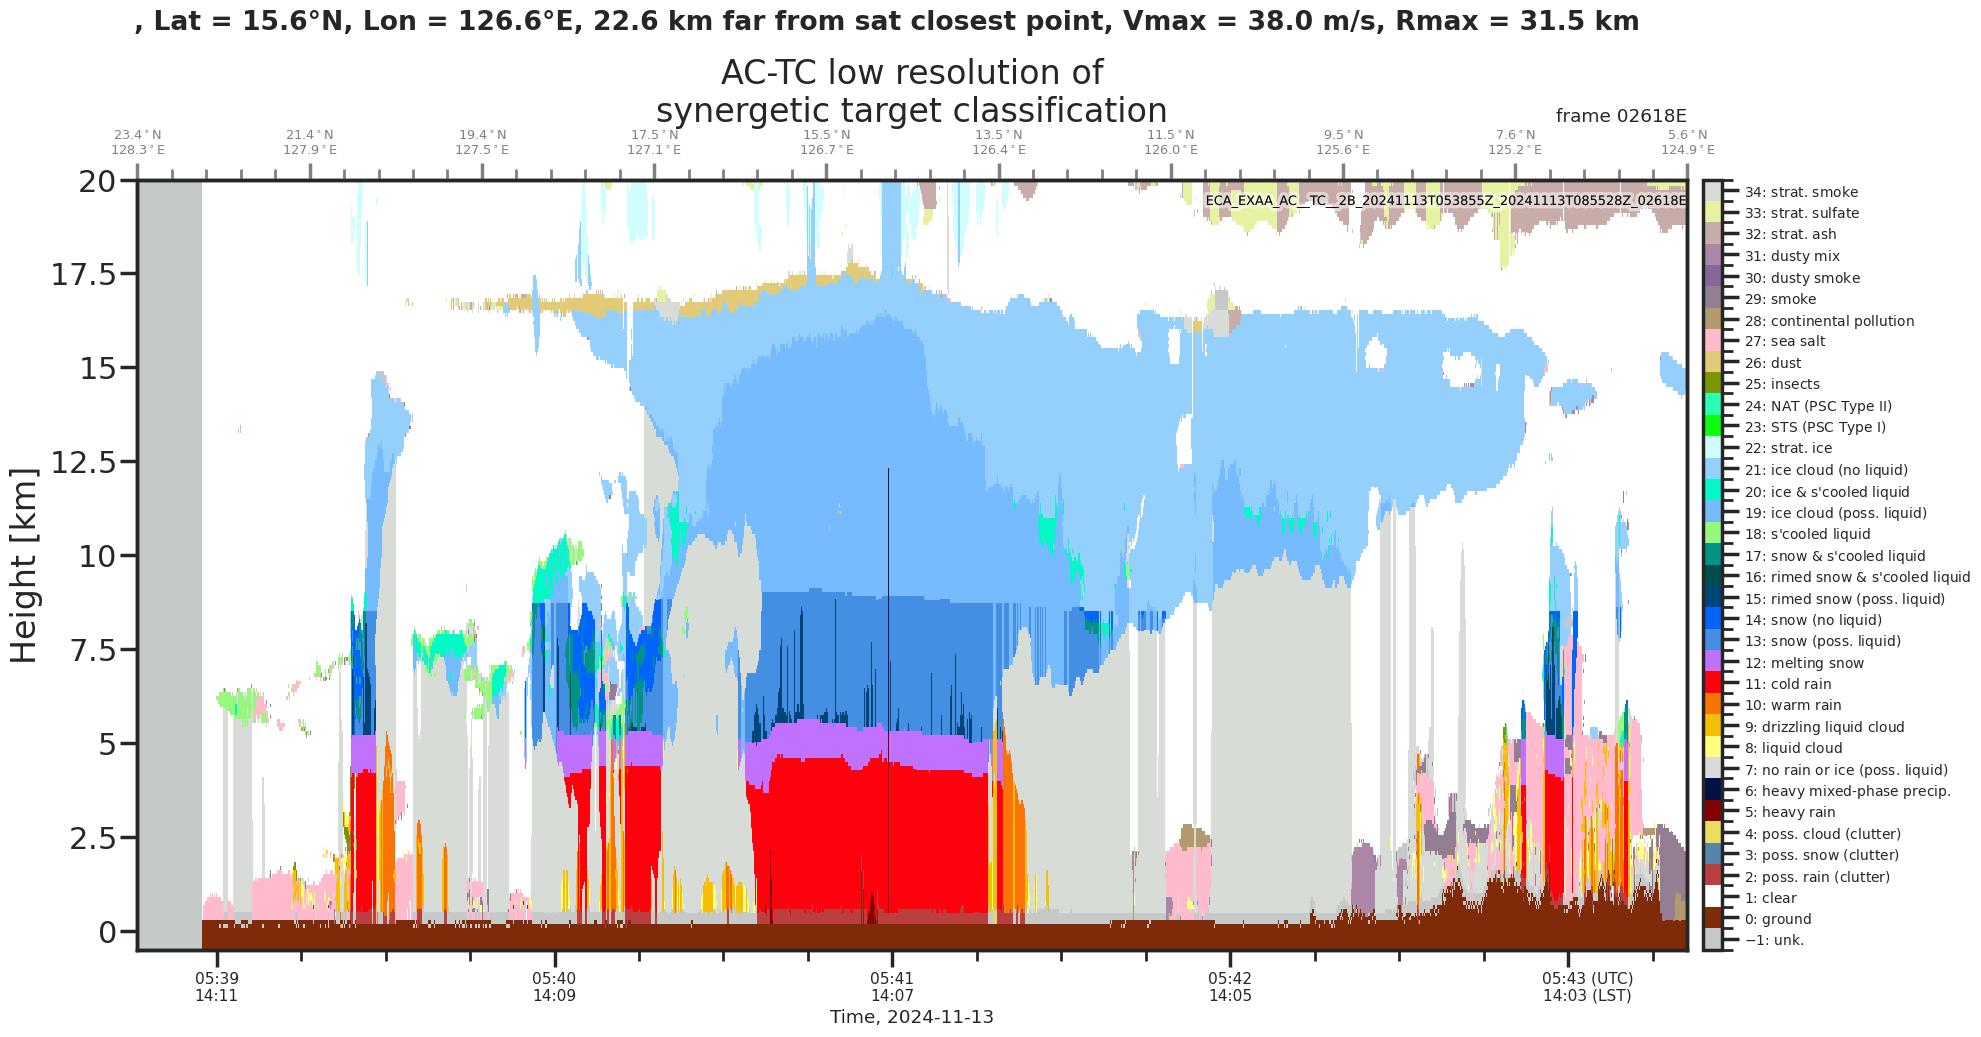

54.23535507814613
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/11/17/ECA_EXAA_AC__TC__2B_20241117T212924Z_20241117T225131Z_02691A.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241117T212924Z_20241117T225131Z_02691A.nc
-17.019572559972318 69.6804247615854
SH022025
2024-11-17T21:35:13.828453331
Vmax = 54.2 m/s
Rmax = 22.2 km 
Trimming by latitude


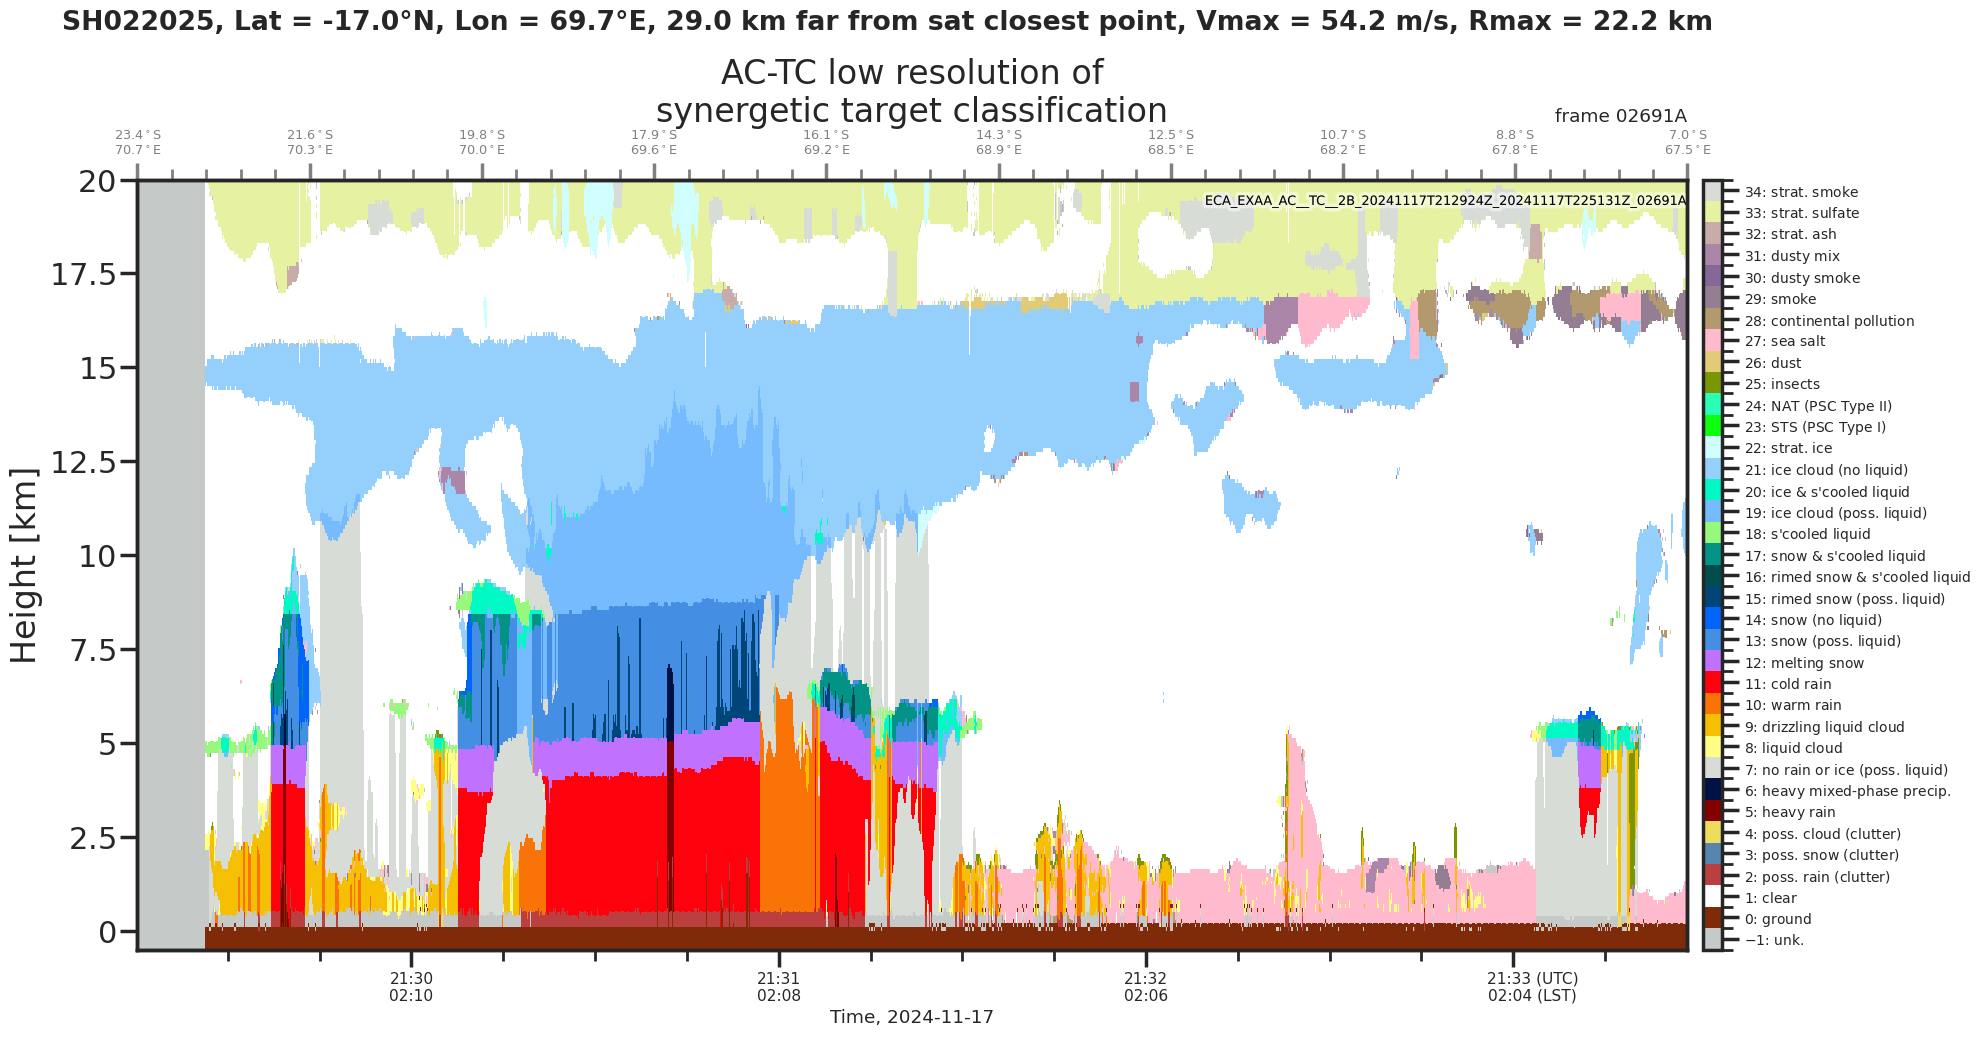

45.648574080668325
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/11/18/ECA_EXAA_AC__TC__2B_20241118T090328Z_20241118T103642Z_02698E.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241118T090328Z_20241118T103642Z_02698E.nc
-17.5 69.18965286470745
SH022025
2024-11-18T09:09:18.589074204
Vmax = 45.6 m/s
Rmax = 28.0 km 
Trimming by latitude


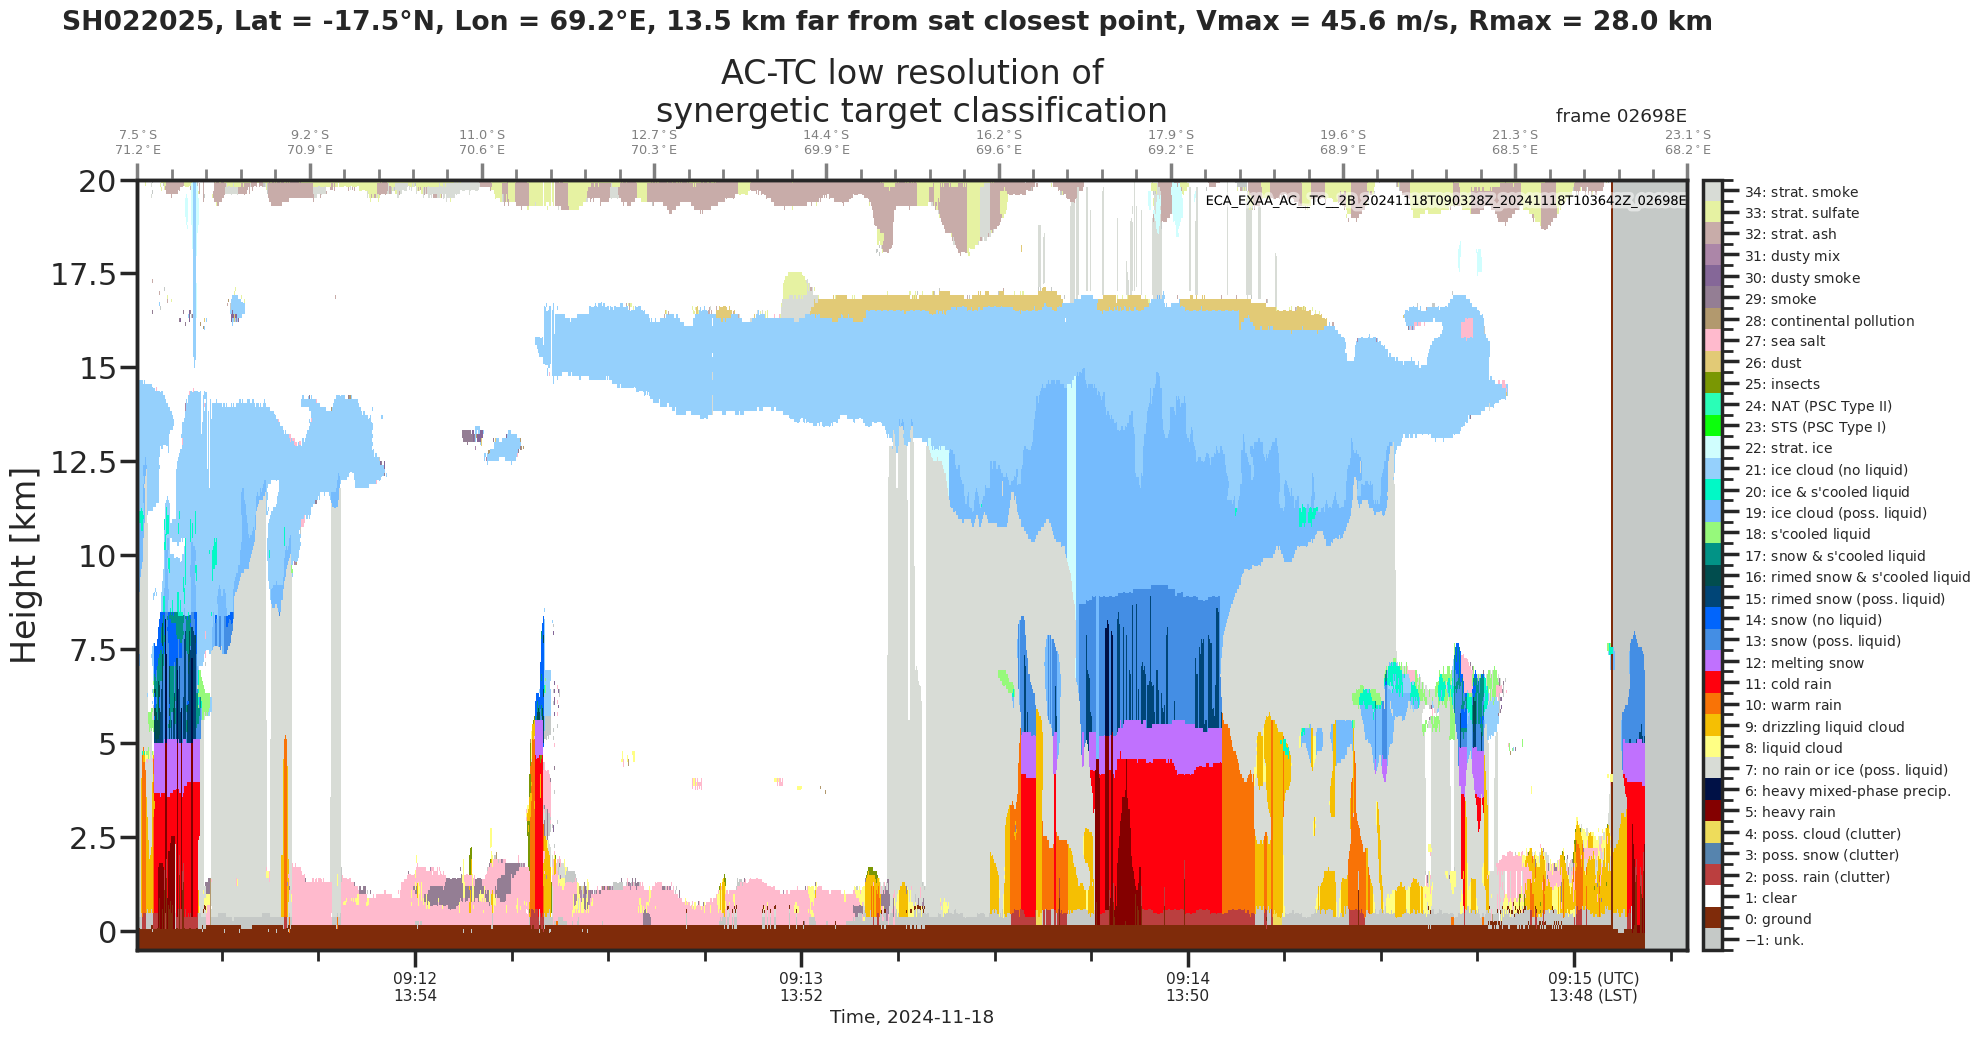

65.84320068359375
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2025/02/07/ECA_EXAA_AC__TC__2B_20250207T082755Z_20250207T100400Z_03958E.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20250207T082755Z_20250207T100400Z_03958E.nc
-19.88542108523836 77.78746870411847
SH132025
2025-02-07T08:33:45.524450557
Vmax = 65.8 m/s
Rmax = 18.5 km 
Trimming by latitude


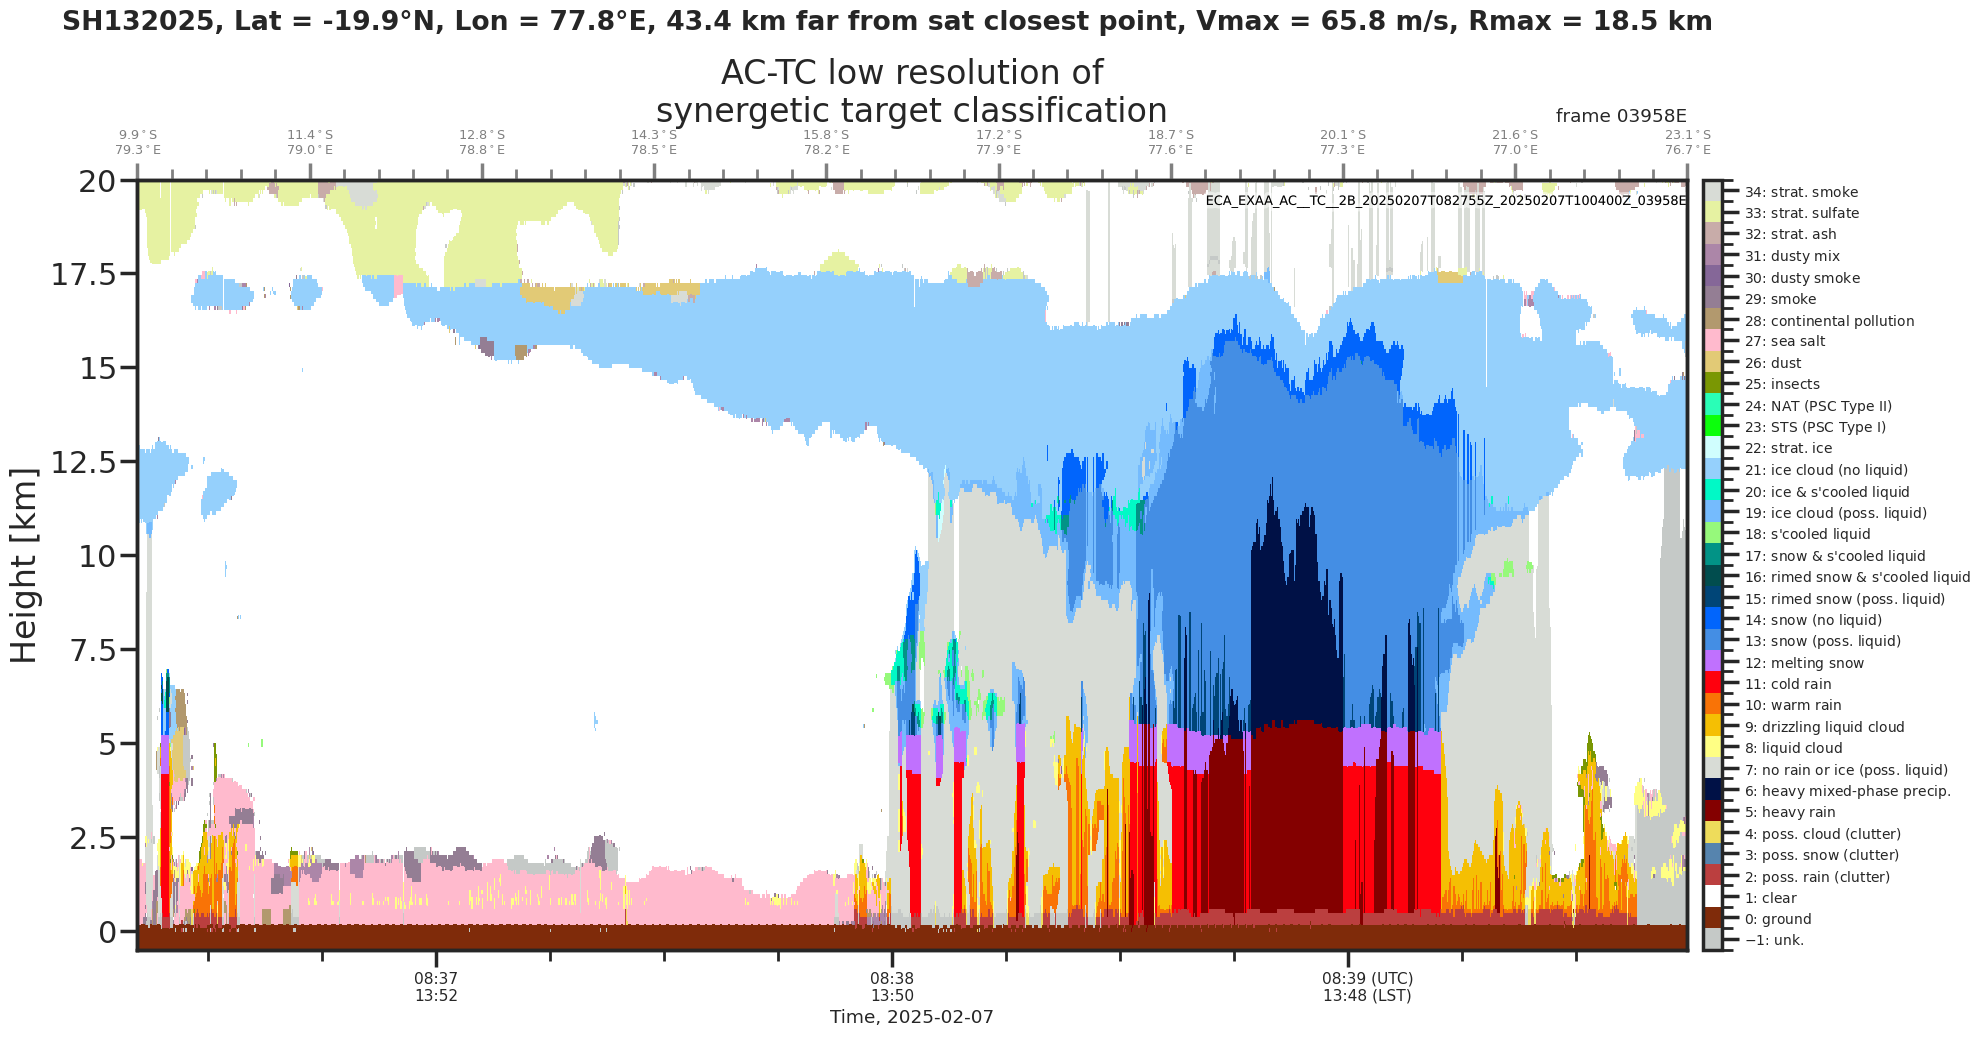

50.46752910521238
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AB/2025/02/25/ECA_EXAB_AC__TC__2B_20250225T064733Z_20250225T090540Z_04237E.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAB_AC__TC__2B_20250225T064733Z_20250225T090540Z_04237E.nc
-22.118733019125372 102.19999694824219
SH202025
2025-02-25T06:53:25.794613605
Vmax = 50.5 m/s
Rmax = 18.5 km 
Trimming by latitude


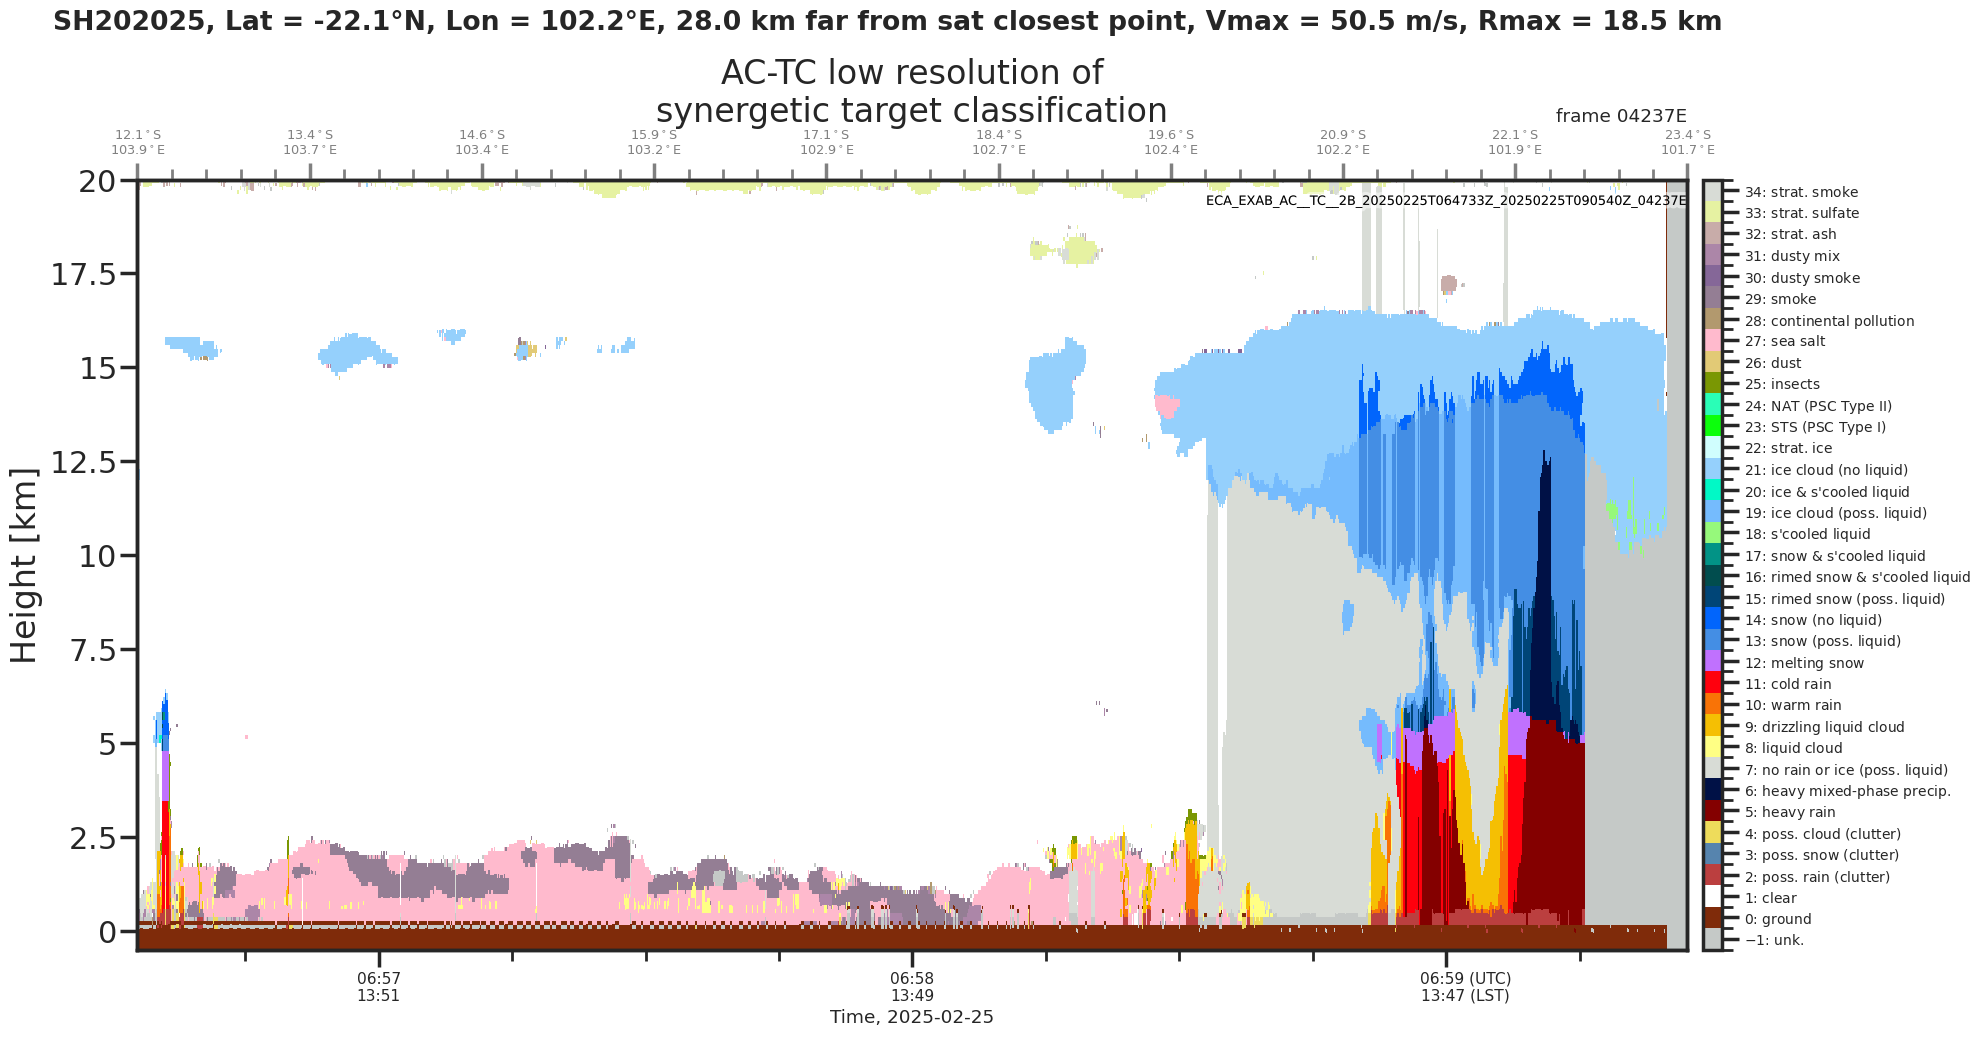

50.36719935053058
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AB/2025/02/25/ECA_EXAB_AC__TC__2B_20250225T065909Z_20250225T090540Z_04237F.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAB_AC__TC__2B_20250225T065909Z_20250225T090540Z_04237F.nc
-22.144738608797486 102.19999694824219
SH202025
2025-02-25T07:05:07.946204376
Vmax = 50.4 m/s
Rmax = 18.5 km 
Trimming by latitude


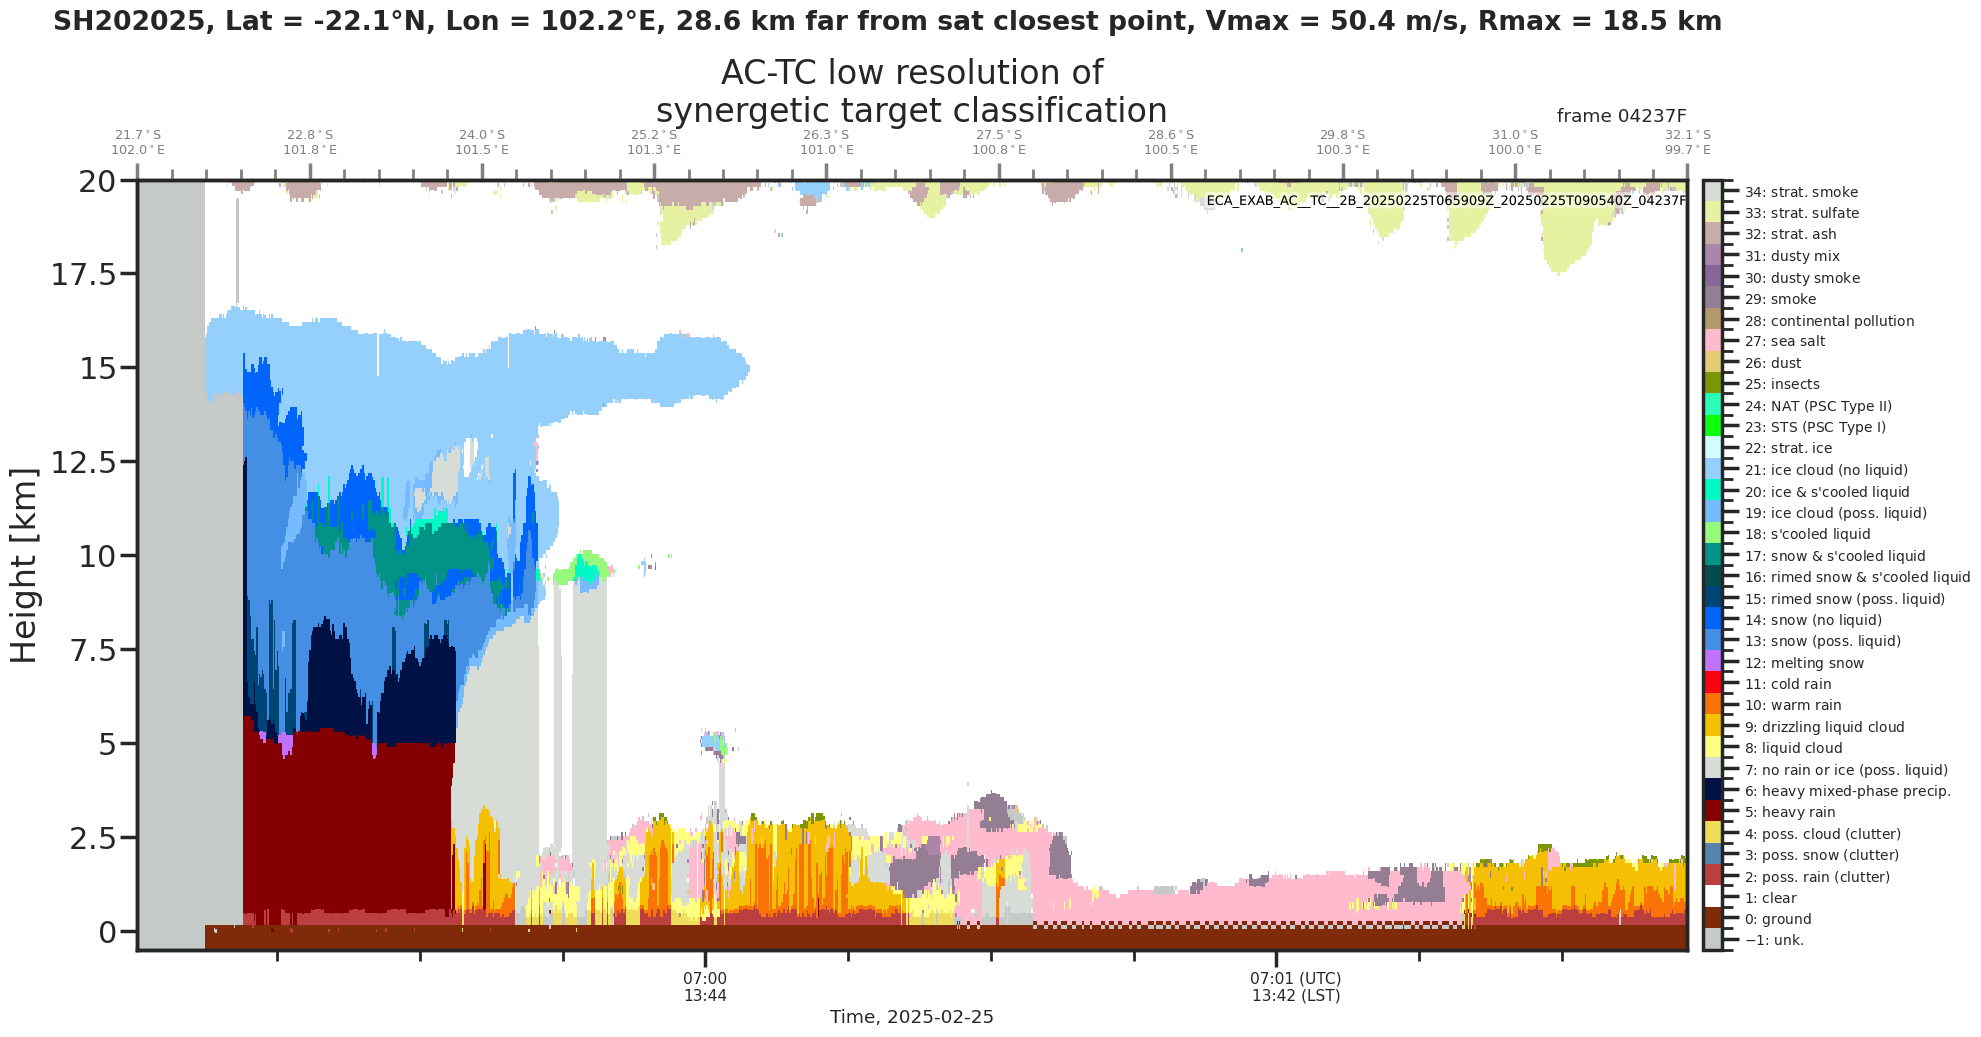

54.012001037597656
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AB/2025/02/28/ECA_EXAB_AC__TC__2B_20250228T154622Z_20250228T212455Z_04290A.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAB_AC__TC__2B_20250228T154622Z_20250228T212455Z_04290A.nc
-20.78707009437541 155.60000610351562
SH182025
2025-02-28T15:52:14.503943086
Vmax = 54.0 m/s
Rmax = 9.3 km 
Trimming by latitude


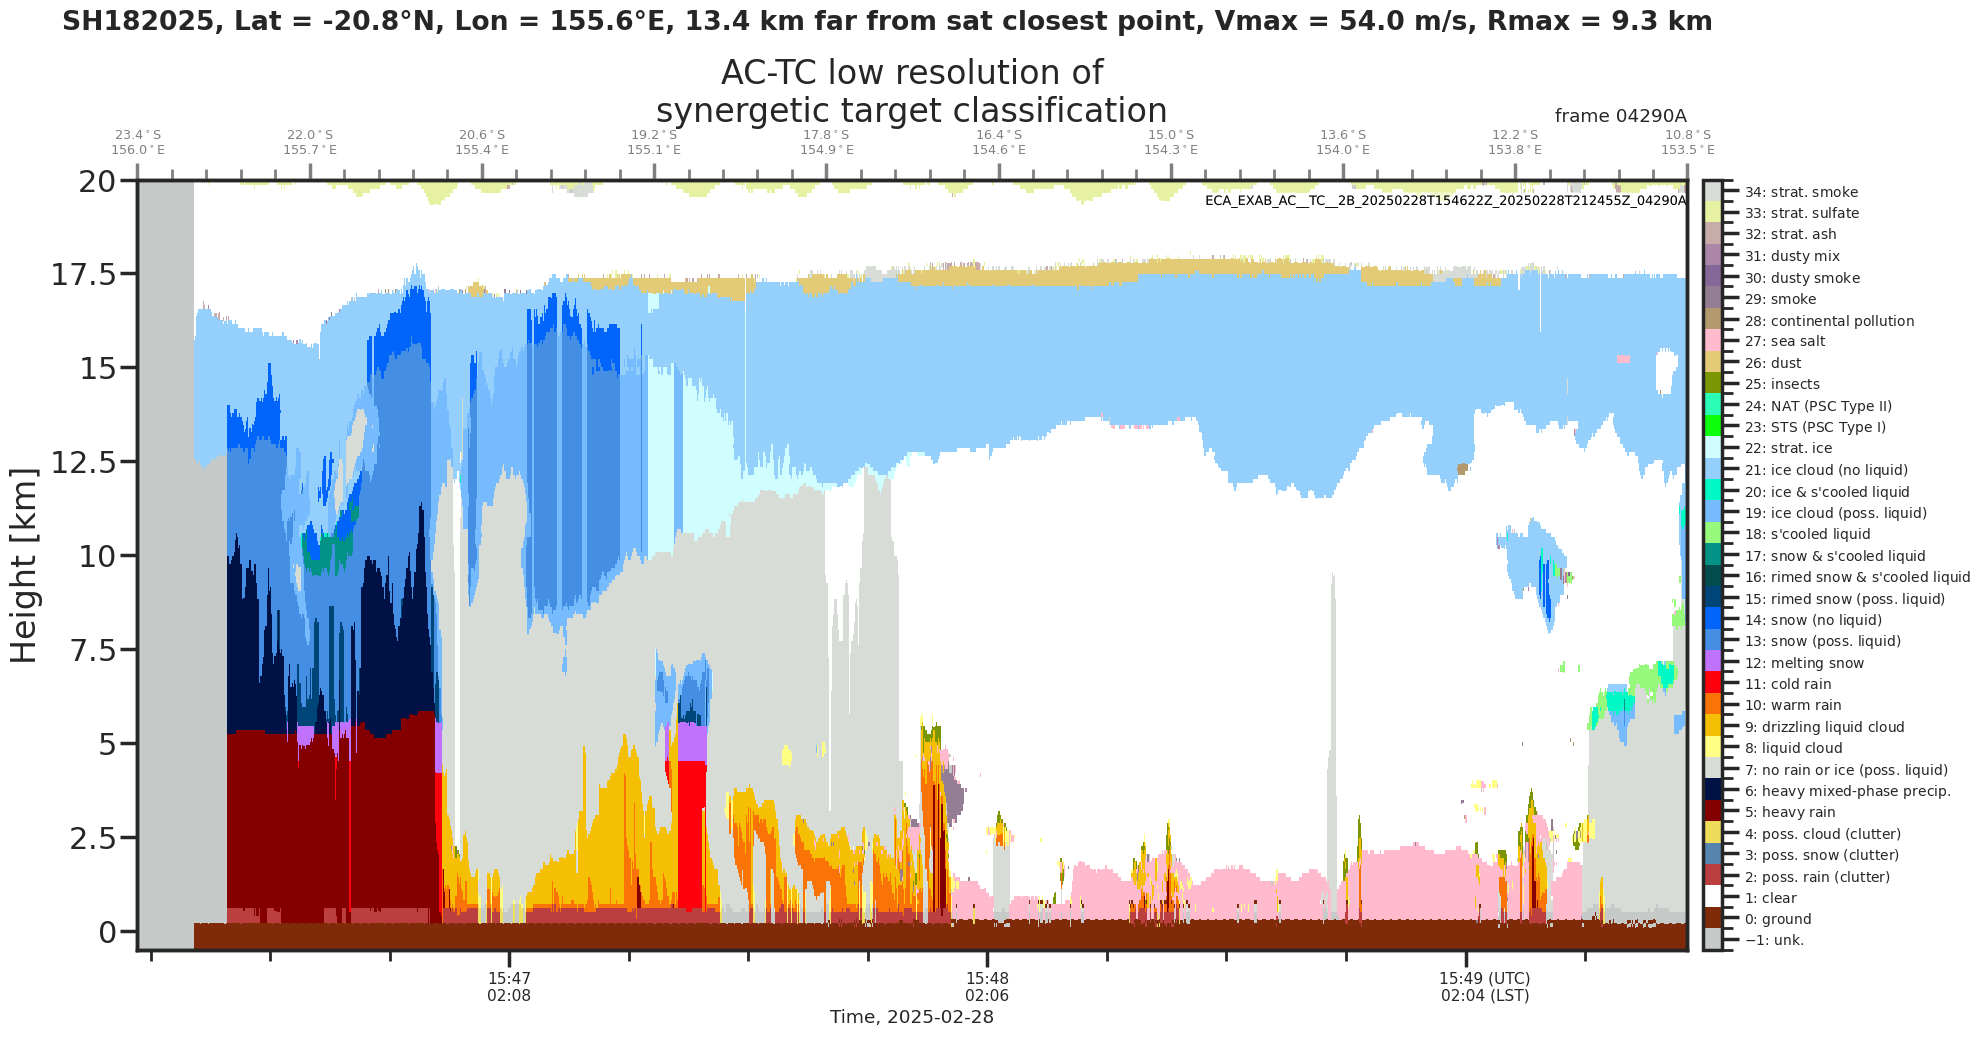

In [8]:
list_of_files  = []
list_of_frames = []

for file in tqdm(all_data):
    ds = xr.open_dataset(file)

    if (ds.vmx_ibt >= 33) & (ds.closest_distance_to_track_center_ibt <= 50000):
        list_of_frames.append(os.path.basename(file).split('.')[0].split('_')[-1])
        list_of_files.append(os.path.basename(file))
        
        # Display
        print(ds.vmx_ibt.values)
        print(ds.file.item())
        print(file)
        print(float(ds.lat_ibt), float(ds.lon_ibt))
        print(ds.atcf_id_ibt.item())
        print(ds.time.mean().data)
        print('Vmax = {:.1f} m/s'.format(ds.vmx_ibt))
        print('Rmax = {:.1f} km '.format(ds.rmx_ibt / 1000))

        # Latitudes are not necessarily ordererd from South to North
        # This may cause a trimming error when choosing lat_boundaries
        dx = 10
        if ds.latitude[1] - ds.latitude[0] > 0: # satellite goes from South to North
            lat_boundaries = [float(ds.lat_ibt) - dx, float(ds.lat_ibt) + dx]
        else:
            lat_boundaries = [float(ds.lat_ibt) + dx, float(ds.lat_ibt) - dx]

        # Load
        ACTC = ecio.load_ACTC(
            ds.file.item(),
            trim={'latitude': slice(lat_boundaries[0], lat_boundaries[1])}
        )

        # Plot
        fig, ax  = plt.subplots(figsize=(20, 10))
        title    = '{}, Lat = {:.1f}°N, Lon = {:.1f}°E, {:.1f} km far from sat closest point, Vmax = {:.1f} m/s, Rmax = {:.1f} km'.format(ds.atcf_id_ibt.item(), ds.lat_ibt, ds.lon_ibt, ds.closest_distance_to_track_center_ibt / 1000, ds.vmx_ibt, ds.rmx_ibt / 1000)
        fig.suptitle(title, y=1.05, weight='bold')
        ecplt.plot_EC_target_classification(ax, ACTC, 'synergetic_target_classification_low_resolution', ACTC_category_colors, title_prefix="", label_fontsize=10, hmax=hmax)

        # Save
        # plt.savefig(PTHS['sav_dir'] + os.path.basename(file)[:-3] + '.png', bbox_inches='tight');plt.clf()
        plt.show()
        
    ds.close()

In [9]:
print(list_of_frames)
print(list_of_files)

['01708B', '02089A', '02089B', '02618E', '02691A', '02698E', '03958E', '04237E', '04237F', '04290A']
['ECA_EXAA_AC__TC__2B_20240915T172841Z_20240915T232259Z_01708B.nc', 'ECA_EXAA_AC__TC__2B_20241010T045647Z_20241010T104700Z_02089A.nc', 'ECA_EXAA_AC__TC__2B_20241010T050822Z_20241010T104634Z_02089B.nc', 'ECA_EXAA_AC__TC__2B_20241113T053855Z_20241113T085528Z_02618E.nc', 'ECA_EXAA_AC__TC__2B_20241117T212924Z_20241117T225131Z_02691A.nc', 'ECA_EXAA_AC__TC__2B_20241118T090328Z_20241118T103642Z_02698E.nc', 'ECA_EXAA_AC__TC__2B_20250207T082755Z_20250207T100400Z_03958E.nc', 'ECA_EXAB_AC__TC__2B_20250225T064733Z_20250225T090540Z_04237E.nc', 'ECA_EXAB_AC__TC__2B_20250225T065909Z_20250225T090540Z_04237F.nc', 'ECA_EXAB_AC__TC__2B_20250228T154622Z_20250228T212455Z_04290A.nc']


### Plotting all overpasses in a TC reference frame

In [10]:
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

  0%|          | 0/418 [00:00<?, ?it/s]

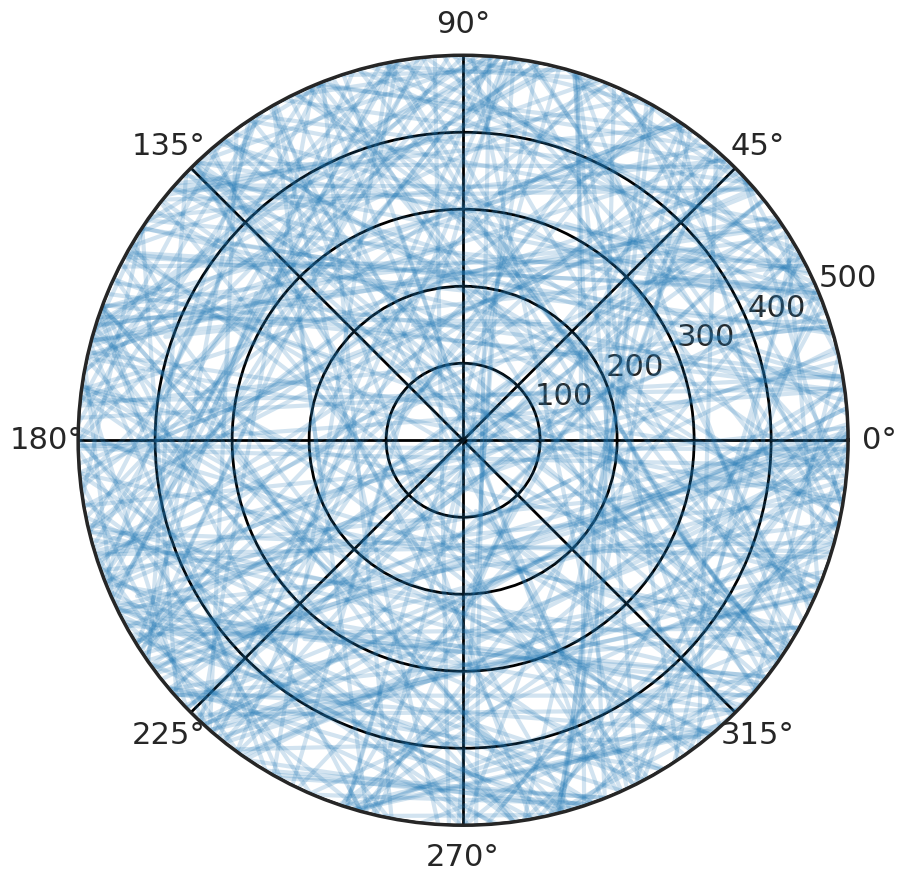

In [11]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for file in tqdm(all_data):
    # Open file
    ds = xr.open_dataset(file)
    
    # Compute polar coordinates of EarthCARE
    # We also rotate the storm
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(ds.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # Plot
    ax.plot(np.deg2rad(ds.th), ds.r / 1000, c='tab:blue', alpha=0.2)

    # Close dataset
    ds.close()

ax.set_rmax(500)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, color='k', linewidth=2)

  0%|          | 0/418 [00:00<?, ?it/s]

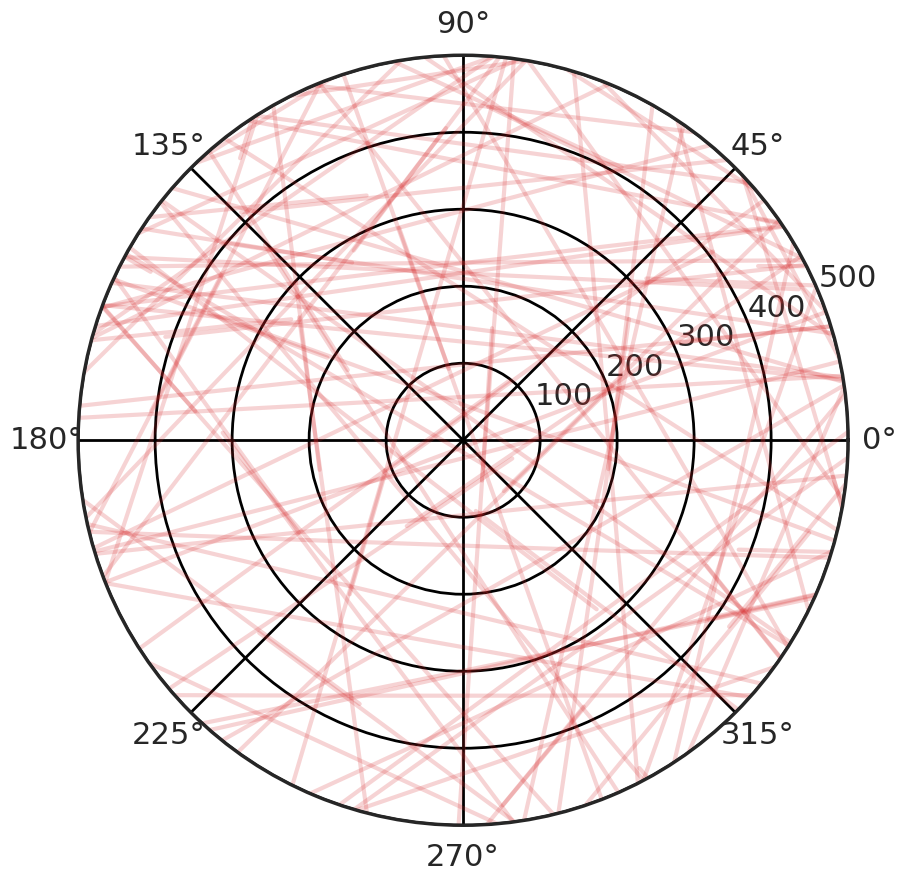

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for file in tqdm(all_data):
    # Open file
    ds = xr.open_dataset(file)

    if ds.vmx_ibt >= 33:
        # Compute polar coordinates of EarthCARE
        # We also rotate the storm
        geod_wgs84        = CRS("epsg:4326").get_geod()
        forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
        forward_az        = forward_az - float(ds.storm_dir_ibt)
        th                = get_polar_theta(forward_az) # r is dr
        ds['r']           = xr.DataArray(data=dr, dims=['ray'])
        ds['th']          = xr.DataArray(data=th, dims=['ray'])
    
        # Plot
        ax.plot(np.deg2rad(ds.th), ds.r / 1000, c='tab:red', alpha=0.2)

    # Close dataset
    ds.close()

ax.set_rmax(500)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, color='k', linewidth=2)

  0%|          | 0/418 [00:00<?, ?it/s]

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, ''),
  Text(1.5707963267948966, 0, ''),
  Text(3.141592653589793, 0, ''),
  Text(4.71238898038469, 0, '')])

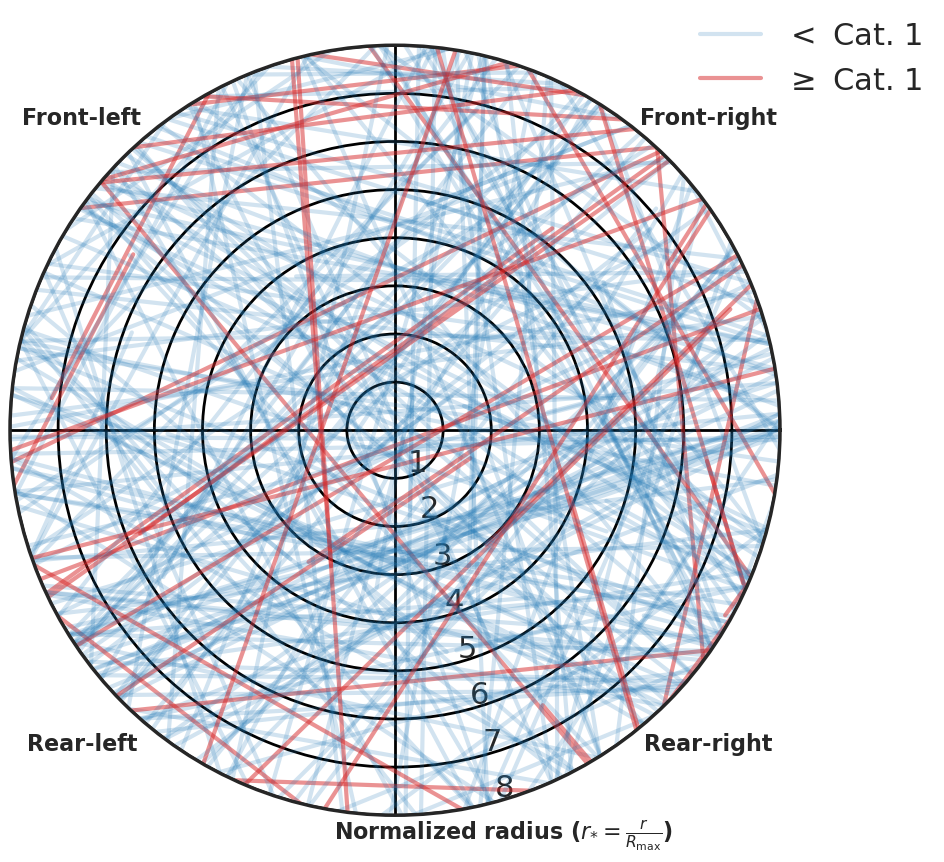

In [48]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# fig.suptitle('EarthCARE tracks overpassing tropical cyclones', weight='bold', y=1.02)
# plt.title('All considered cyclones move toward the top of the figure\n'r'Radial axis is $r^{*} = \frac{r}{R_{\text{max}}}$', fontsize=14)

for file in tqdm(all_data):
    # Open file
    ds = xr.open_dataset(file)
    
    # Compute polar coordinates of EarthCARE
    # We also rotate the storm
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(ds.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # CAVEAT: Flip Southern hemisphere
    if ds.lat_ibt < 0:
        ds['th'] = 180 - ds['th']

    # Plot
    if ds.vmx_ibt >= 33:
        ax.plot(np.deg2rad(ds.th), ds.r / ds.rmx_ibt, c='tab:red',  alpha=0.5, label=r'$\geq$ Cat. 1')
    else:
        ax.plot(np.deg2rad(ds.th), ds.r / ds.rmx_ibt, c='tab:blue', alpha=0.2, label=r'$<$ Cat. 1')

    # Close dataset
    ds.close()

# Display unique handles and labels
# handles, labels = plt.gca().get_Save
handles, labels = ax.get_legend_handles_labels()
by_label        = dict(zip(labels, handles)) # Create a dictionary to stock handles by unique label
ax.legend(by_label.values(), by_label.keys(), frameon=False, loc=(0.88, 0.92)) # Display legend with unique labels

# Grid
ax.set_rmax(8)
ax.grid(True, color='k', linewidth=2)

# Legend for r
ax.set_rlabel_position(285) 
ax.text(np.deg2rad(285), ax.get_rmax() + 0.7, 
        r'Normalized radius ($r_{\text{*}} = \frac{r}{R_{\text{max}}}$)', 
        ha='center', va='center', fontsize=16, weight='bold')

# Legend for theta
quadrant_degrees = [45, 135, 225, 315]
quadrant_labels = ['Front-right', 'Front-left', 'Rear-left', 'Rear-right']
label_radius = ax.get_rmax() + 1.2 # Place text slightly outside the grid boundary
for angle_deg, label in zip(quadrant_degrees, quadrant_labels):
    angle_rad = np.deg2rad(angle_deg)
    ax.text(angle_rad, 
            label_radius, 
            label, 
            ha='center', 
            va='center', 
            fontsize=16, 
            weight='bold') 
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_thetagrids([0, 90, 180, 270], labels=[], color='gray')


# # Save
# plt.savefig(PTHS['sav_dir'] + 'EC_TC_tracks' + '.png', bbox_inches='tight');plt.clf()

In [21]:
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# for file in tqdm(all_data):
#     # Open file
#     ds = xr.open_dataset(file)

#     if ds.vmx_ibt >= 33:
#         # Compute polar coordinates of EarthCARE
#         # We also rotate the storm
#         geod_wgs84        = CRS("epsg:4326").get_geod()
#         forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
#         forward_az        = forward_az - float(ds.storm_dir_ibt)
#         th                = get_polar_theta(forward_az) # r is dr
#         ds['r']           = xr.DataArray(data=dr, dims=['ray'])
#         ds['th']          = xr.DataArray(data=th, dims=['ray'])
    
#         # Plot
#         ax.plot(np.deg2rad(ds.th), ds.r / ds.rmx_ibt, c='tab:red', alpha=0.2)

#     # Close dataset
#     ds.close()

# ax.set_rmax(8)
# # ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# # ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True, color='k', linewidth=2)

In [7]:
# # Compute polar coordinates of EarthCARE
# # We also rotate the storm
# geod_wgs84        = CRS("epsg:4326").get_geod()
# forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
# forward_az        = forward_az - float(ds.storm_dir_ibt)
# th                = get_polar_theta(forward_az) # r is dr

# ds['r']           = xr.DataArray(data=dr, dims=['ray'])
# ds['th']          = xr.DataArray(data=th, dims=['ray'])

# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# ax.plot(np.deg2rad(ds.th), ds.r / 1000)
# ax.set_rmax(500)
# # ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# # ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True)

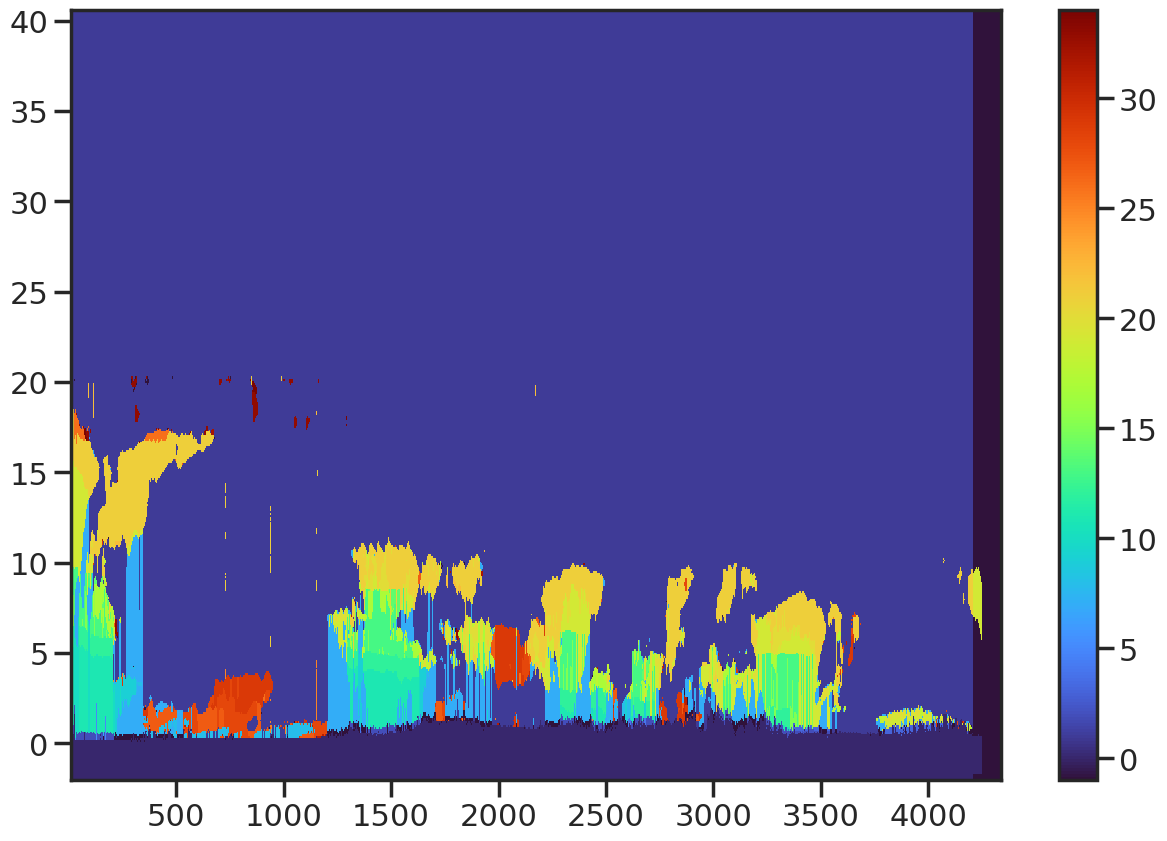

In [35]:
# Plot transect
RS = np.tile(ds.r, (len(ds.JSG_height), 1)).transpose()
plt.pcolor(RS / 1000, ds.height / 1000, ds.synergetic_target_classification, cmap='turbo')
plt.colorbar()

In [13]:
# p  = '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20250112T105253Z_20250112T123739Z_03555E.nc'
# ds = xr.open_dataset(p)

In [12]:
# # Display
# print(ds.vmx_ibt.values)
# print(ds.file.item())
# print(file)
# print(float(ds.lat_ibt), float(ds.lon_ibt))
# print(ds.atcf_id_ibt.item())
# print(ds.time.mean().data)
# print('Vmax = {:.1f} m/s'.format(ds.vmx_ibt))
# print('Rmax = {:.1f} km '.format(ds.rmx_ibt / 1000))

# # Latitudes are not necessarily ordererd from South to North
# # This may cause a trimming error when choosing lat_boundaries
# dx = 10
# if ds.latitude[1] - ds.latitude[0] > 0: # satellite goes from South to North
#     lat_boundaries = [float(ds.lat_ibt) - dx, float(ds.lat_ibt) + dx]
# else:
#     lat_boundaries = [float(ds.lat_ibt) + dx, float(ds.lat_ibt) - dx]

# # Load
# ACTC = ecio.load_ACTC(
#     ds.file.item(),
#     trim={'latitude': slice(lat_boundaries[0], lat_boundaries[1])}
# )

# # Plot
# fig, ax  = plt.subplots(figsize=(20, 10))
# title    = '{}, Lat = {:.1f}°N, Lon = {:.1f}°E, {:.1f} km far from sat closest point, Vmax = {:.1f} m/s, Rmax = {:.1f} km'.format(ds.atcf_id_ibt.item(), ds.lat_ibt, ds.lon_ibt, ds.closest_distance_to_track_center_ibt / 1000, ds.vmx_ibt, ds.rmx_ibt / 1000)
# fig.suptitle(title, y=1.05, weight='bold')
# ecplt.plot_EC_target_classification(ax, ACTC, 'synergetic_target_classification_low_resolution', ACTC_category_colors, title_prefix="", label_fontsize=10, hmax=hmax)

In [7]:
d = xr.open_dataset('/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241028T170932Z_20241028T230948Z_02377A.nc')
print(float(d.lat_ibt), float(d.lon_ibt))
print(d.atcf_id_ibt.item())
print(d.time.mean().data)
print('Rmax = {:.1f} km'.format(d.rmx_ibt / 1000))
lat_boundaries = [2.5, 22.5]

ACTC = ecio.load_ACTC(
    '/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/2024/10/28/ECA_EXAA_AC__TC__2B_20241028T170932Z_20241028T230948Z_02377A.h5',
    trim={'latitude': slice(lat_boundaries[0], lat_boundaries[1])}
)

17.125628177719555 127.97437269255973
WP232024
2024-10-28T17:15:22.597185501
Rmax = 49.1 km
Trimming by latitude


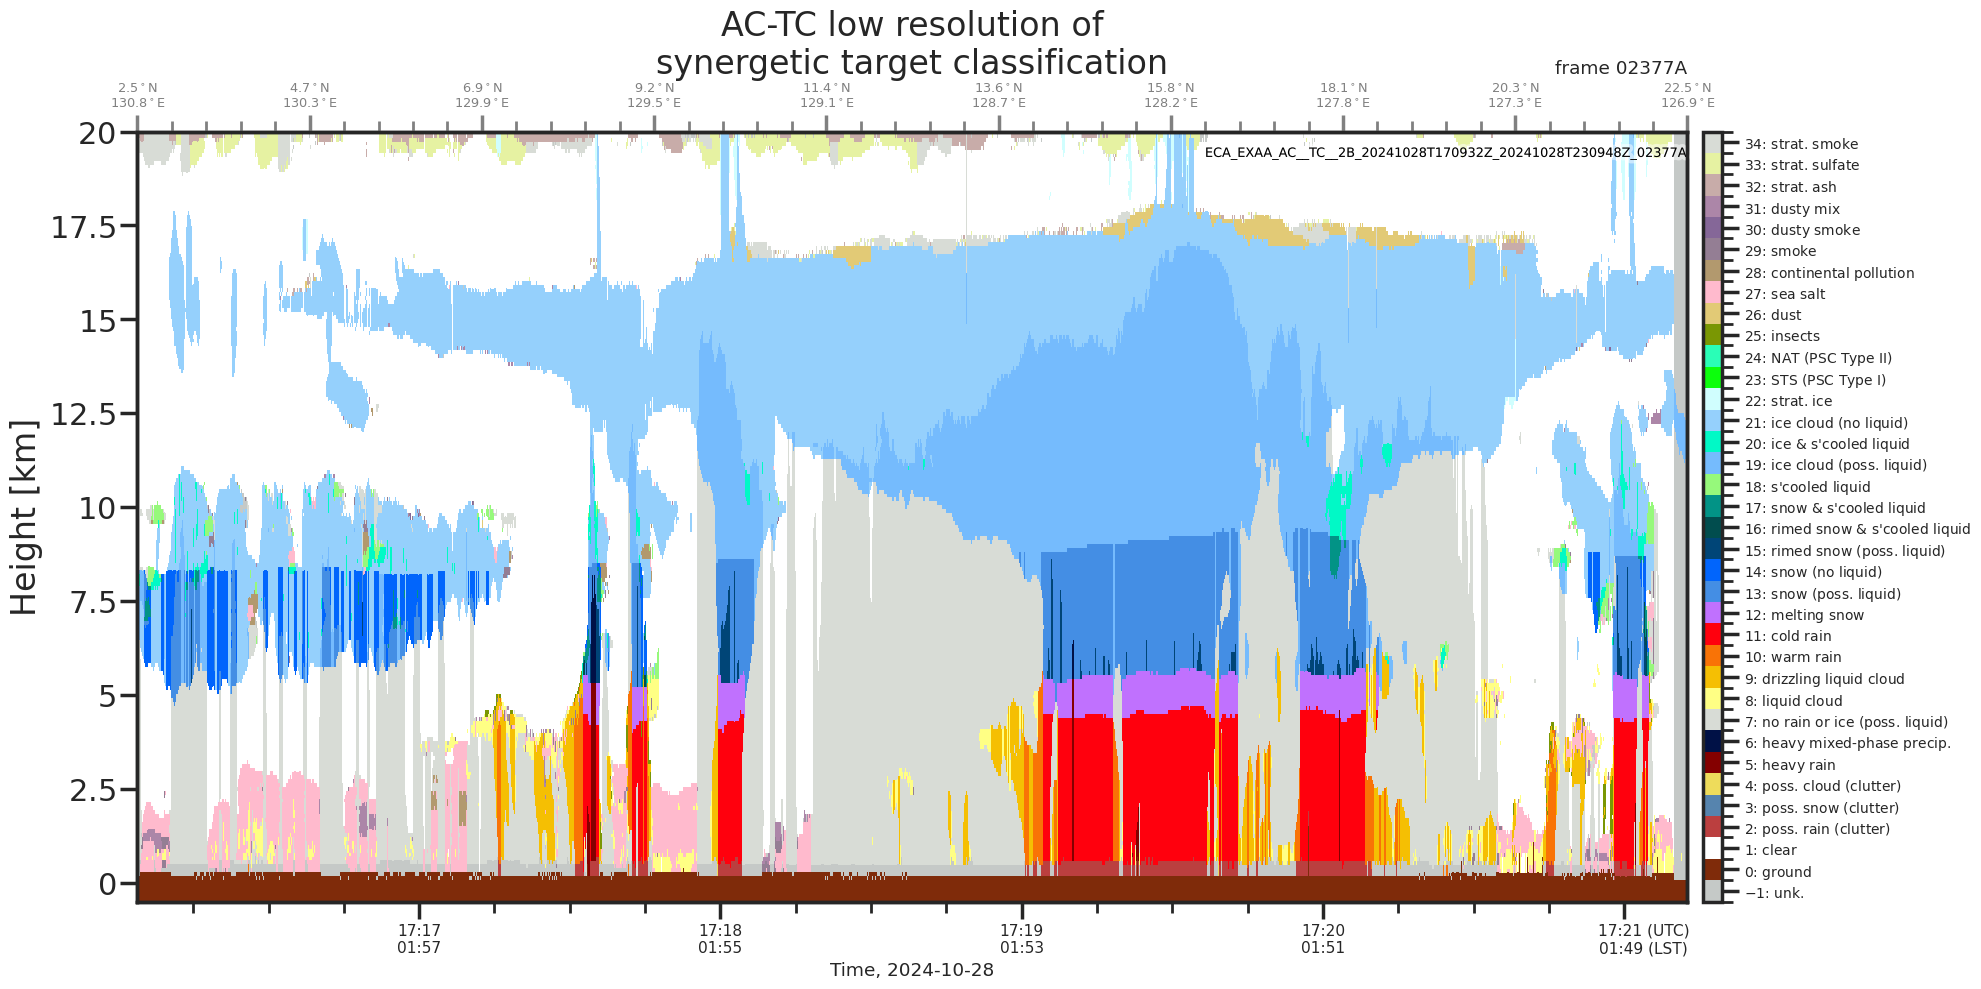

In [8]:
fig, ax  = plt.subplots(figsize=(20, 10))

ecplt.plot_EC_target_classification(ax, ACTC, 'synergetic_target_classification_low_resolution', ACTC_category_colors, title_prefix="", label_fontsize=10, hmax=hmax)

# plt.savefig(PTHS['sav_dir'] + 'Leslie_Classification', bbox_inches='tight')